In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch .utils.data import  DataLoader
from torchvision.transforms import ToTensor,Resize, Normalize
from torchvision import transforms
import os
import torchvision
import matplotlib.pyplot as plt
from torchvision import models
import time
import copy
from datetime import timedelta

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = "/content/drive/MyDrive/hymenoptera_data"
os.listdir(root_dir)

['train', 'val']

In [4]:
mean = [0.5, 0.5, 0.5]
std = [0.25, 0.25, 0.25]
transformation = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

In [5]:
train_data = ImageFolder(root = os.path.join(root_dir, 'train'),
                         transform = transformation)
val_data = ImageFolder(root = os.path.join(root_dir,'val'),
                       transform = transformation)
idx_to_class1 = {j:i for i, j in train_data.class_to_idx.items()}

In [6]:
batch = 4
train_dataloader = DataLoader(train_data, batch_size = batch, shuffle=True, num_workers = 0)
test_dataloader = DataLoader(val_data, batch_size = batch, shuffle=True, num_workers = 0)


In [49]:
def img_show(tensor, title):
    tensor = tensor.numpy().transpose((1, 2, 0))
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    plt.figure(figsize=(15,40))
    plt.imshow(tensor)
    plt.title(title)
    plt.show()

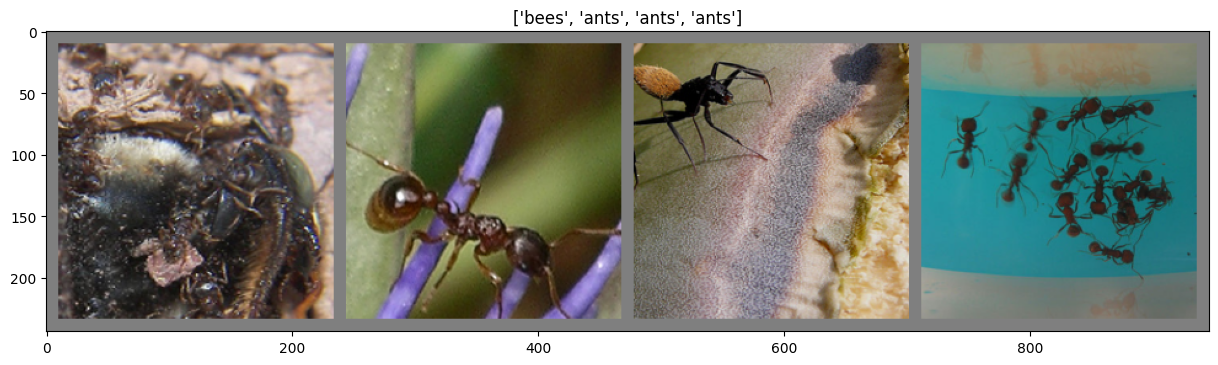

In [54]:

inputs, classes = next(iter(train_dataloader))

grid = torchvision.utils.make_grid(inputs, nrow = 4, padding = 10)

img_show(grid, title=[idx_to_class1[int(x.numpy())] for x in classes])

In [67]:

model = models.resnet18(pretrained = True)
fc_num_infeatures = model.fc.in_features
model.fc = nn.Linear(fc_num_infeatures, 2)
model = model.to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

step_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [9]:
def train(epoch, dataloader):
    model.train()
    torch.autograd.set_detect_anomaly(True)
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

In [22]:
def evaluate_model(data_loader,model,loss, correct):
    for data, target in data_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          _, pred = torch.max(output,1)#output.data.max(1, keepdim=True)[1]
          loss += criterion(output, target).item()
          correct += pred.eq(target.data.view_as(pred)).sum()
    return loss, correct

In [27]:
def test(train_dataloader, test_dataloader):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
      loss, correct = evaluate_model(train_dataloader,model,loss, correct)
      loss /= len(test_dataloader.dataset)
      print(f'train loss: {loss}, acc: {correct/len(train_dataloader.dataset)}')
      correct, loss = 0, 0
      loss, correct = evaluate_model(test_dataloader,model,loss, correct)
      loss /= len(test_dataloader.dataset)
      print(f'test loss: {loss}, acc: {correct/len(test_dataloader.dataset)}')


In [68]:
def train_model(model, criterion, optimizer, scheduler, n_epochs):
  start_time = time.time()

  for epoch in range(1, n_epochs + 1):
    print(f'Epoch {epoch}/{n_epochs}')
    print('-' * 10)
    train(epoch, train_dataloader)
    test(train_dataloader,test_dataloader)
    step_lr_scheduler.step()

  print(f'\n Train time: {str(timedelta(seconds=(time.time()-start_time)))} ')



In [29]:
train_model(model, criterion, optimizer, step_lr_scheduler, 5)

Epoch 1/5
----------
train loss: 0.05485889556044652, acc: 0.9672130346298218
test loss: 0.04786778315658273, acc: 0.9542483687400818
Epoch 2/5
----------
train loss: 0.07107804662067127, acc: 0.9426229000091553
test loss: 0.06025474966546289, acc: 0.9084967374801636
Epoch 3/5
----------
train loss: 0.05865758844937374, acc: 0.9631146788597107
test loss: 0.05723746924423704, acc: 0.9477124214172363
Epoch 4/5
----------
train loss: 0.06297971416581301, acc: 0.9508196115493774
test loss: 0.06092419870976919, acc: 0.915032684803009
Epoch 5/5
----------
train loss: 0.053163446766001723, acc: 0.9713114500045776
test loss: 0.058360029912851996, acc: 0.9084967374801636

 Train time: 54.043078899383545 


In [62]:
model_freez = models.resnet18(pretrained=True)
for param in model_freez.parameters():
  param.reuires_grad = False

model_freez.fc = nn.Linear(model_freez.fc.in_features,2)

model_freez = model_freez.to(device)
criterion_freez = nn. CrossEntropyLoss()
optimizer_freez = optim.SGD(model_freez.fc.parameters(), lr=0.001, momentum=0.9)
scheduler_freez = optim.lr_scheduler.StepLR(optimizer_freez, step_size=7, gamma=0.1)
_



['train', 'val']

In [69]:
train_model(model_freez, criterion_freez, optimizer_freez, scheduler_freez, 10)

Epoch 1/10
----------
train loss: 0.2053342252190596, acc: 0.7663934230804443
test loss: 0.13202635758842518, acc: 0.7777777910232544
Epoch 2/10
----------
train loss: 0.15044336381301382, acc: 0.8975409269332886
test loss: 0.10214648960657369, acc: 0.8627451062202454
Epoch 3/10
----------
train loss: 0.11537387280487547, acc: 0.9180327653884888
test loss: 0.08079569928007188, acc: 0.8692810535430908
Epoch 4/10
----------
train loss: 0.10116875804717244, acc: 0.9139343500137329
test loss: 0.07028741793694838, acc: 0.9019607901573181
Epoch 5/10
----------
train loss: 0.08991578347932279, acc: 0.9467212557792664
test loss: 0.06885110547924353, acc: 0.8888888955116272
Epoch 6/10
----------
train loss: 0.08055535543198679, acc: 0.9467212557792664
test loss: 0.06364679244024302, acc: 0.9281045794487
Epoch 7/10
----------
train loss: 0.07783818999731462, acc: 0.930327832698822
test loss: 0.0682326413301471, acc: 0.9019607901573181
Epoch 8/10
----------
train loss: 0.06678036224170059, acc: 0